# Performance score prediction notebook

This notebook explores the IoT-Drive Sports Training Dataset from Kaggle. The goal is to predict the performance score for each athlete with numerical features. 

Notes:
* Features such as hear rate, respiration rate, accelerometer readings, gyroscope readings, etc. are assumed to be averages over the duration of the activity

* Data source: Kaggle IoT-Driven Sports Training Dataset (https://www.kaggle.com/datasets/ziya07/iot-driven-sports-training-dataset) by Ziya



In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score

# 1. Import Data

In [2]:
# Data
df = pd.read_csv('iot_sports_training_dataset.csv')
df = df.drop(columns = ['Athlete_ID', 'Injury_Risk', 'Session_ID'])
df.head()

,Age,Gender,Sport,HR,RR,Temp,Accel_X,Accel_Y,Accel_Z,Gyro_X,Gyro_Y,Gyro_Z,Steps,Exercise,Duration,Fatigue,PSD_HR,PSD_Accel_X,PSD_Gyro_Y,Performance_Score
0,24,M,Basketball,137,17,36.2,1.37,0.49,1.11,0.35,0.22,0.15,5524,Running,31,Medium,0.73,0.70,0.53,72
1,32,F,Basketball,146,10,36.3,0.29,0.25,0.70,0.55,0.63,0.94,4459,Endurance,22,Medium,0.62,0.44,0.52,48
2,28,F,Basketball,135,21,36.3,0.89,0.25,1.27,0.40,0.57,0.92,4992,Endurance,58,Low,0.97,0.54,0.54,56
3,25,M,Basketball,119,20,36.6,0.38,0.43,1.06,0.83,0.18,0.89,1203,Drills,33,Medium,0.80,0.66,0.25,47
4,24,F,Football,177,17,36.6,0.22,1.33,1.24,0.81,0.06,0.63,3775,Running,47,Medium,0.55,0.52,0.59,69


# 2. Exploratory Data Analysis

Number of Observations: 500
------------
Column Names and Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                500 non-null    int64  
 1   Gender             500 non-null    object 
 2   Sport              500 non-null    object 
 3   HR                 500 non-null    int64  
 4   RR                 500 non-null    int64  
 5   Temp               500 non-null    float64
 6   Accel_X            500 non-null    float64
 7   Accel_Y            500 non-null    float64
 8   Accel_Z            500 non-null    float64
 9   Gyro_X             500 non-null    float64
 10  Gyro_Y             500 non-null    float64
 11  Gyro_Z             500 non-null    float64
 12  Steps              500 non-null    int64  
 13  Exercise           500 non-null    object 
 14  Duration           500 non-null    int64  
 15  Fatigue  

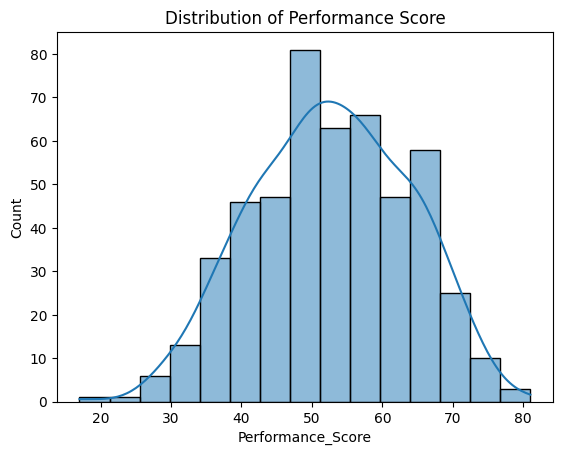

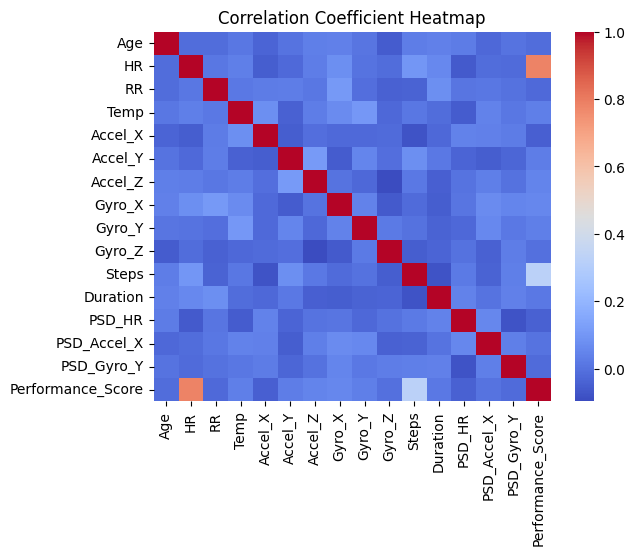

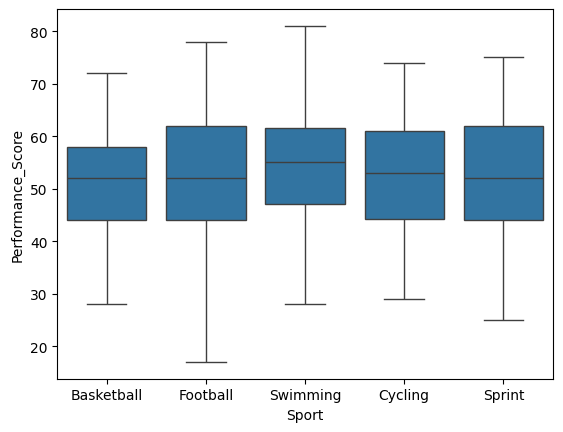

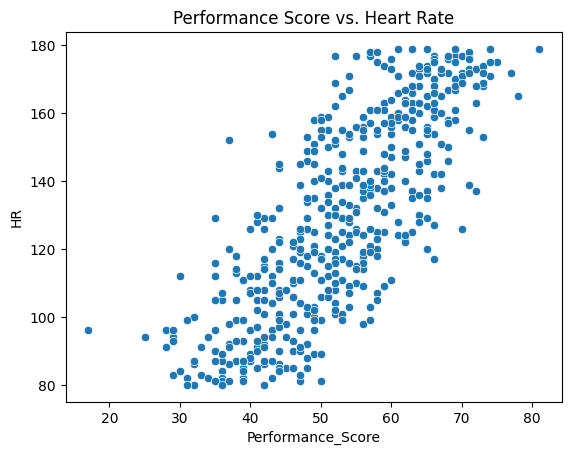

In [3]:
# Exploratory data analysis
# Exploratory Data Analysis
print(f'Number of Observations: {df.shape[0]}')
print('------------')
print('Column Names and Types:')
print(df.info())
print('------------')
print(f'Missing Data:\n{df.isnull().sum()}')
print('------------')
print(f'Summary Stats:\n{df.describe()}')


# Distribution of target variable
sns.histplot(df['Performance_Score'], kde=True)
plt.title('Distribution of Performance Score')
plt.show()

# Correlation Heatmap (numeric data only)
df_corr = df.drop(columns=['Gender', 'Sport', 'Exercise', 'Fatigue'])
sns.heatmap(df_corr.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Coefficient Heatmap')
plt.show()

# Box plot of performance score by sport
sns.boxplot(x='Sport', y='Performance_Score', data=df)
plt.show()

# Scatter plot of heart rate and perforamnce score
sns.scatterplot(x="Performance_Score", y="HR", data=df)
plt.title("Performance Score vs. Heart Rate")
plt.show()


# 3. Train Test Split

In [30]:
# Split data into training and testing set (doing this before other steps maximizes generalizability to new, unseen data)
X = df.drop(['Performance_Score'], axis=1)
y = df['Performance_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# 4. Build out pre-processing pipelines

In [36]:
# Identify numeric features
numeric_feats = X.select_dtypes(include=np.number).columns.tolist()
categorical_feats = X.select_dtypes(exclude=np.number).columns.tolist()

# Pipeline for standardizing numeric features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()),

    # If you want to use PCA for feature reduction
    # (('pca'), PCA(n_components=5))
])

# Pipeline for onehot encoding categorical features
cateogorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Single preprocessing pipeline
preprocessor = ColumnTransformer([
    ('numeric transform', numeric_transformer, numeric_feats),
    ('categorical transform', cateogorical_transformer, categorical_feats)
])

# 5. Process data, fit model, predict on test data, and calculate evaluation metrics

In [37]:
# Create a single model pipeline for pre-processing and fitting data
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit model parameters
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Calculate RMSE and R^2
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics: 
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

RMSE: 7.039362851592769
R^2: 0.5390092867127823


# 6. Analyze coefficients

RMSE and $R^2$ are not great using this feature set. Lets analyze regression coefficients. Low coefficients indicate little contribution to prediction.

In [38]:
# Extract regressor and coefficients
lin_reg = model.named_steps['regressor']
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

coefs = pd.Series(lin_reg.coef_, index=feature_names)

# Sort by absolute importance
coefs_sorted = coefs.reindex(coefs.abs().sort_values(ascending=False).index)

print(coefs_sorted)

categorical transform__Exercise_Cardio       1.650300e+13
categorical transform__Exercise_Running      1.650300e+13
categorical transform__Exercise_Drills       1.650300e+13
categorical transform__Exercise_Lifting      1.650300e+13
categorical transform__Exercise_Endurance    1.650300e+13
categorical transform__Sport_Basketball     -1.237404e+13
categorical transform__Sport_Football       -1.237404e+13
categorical transform__Sport_Cycling        -1.237404e+13
categorical transform__Sport_Sprint         -1.237404e+13
categorical transform__Sport_Swimming       -1.237404e+13
categorical transform__Fatigue_Medium        9.568549e+12
categorical transform__Fatigue_Low           9.568549e+12
categorical transform__Fatigue_High          9.568549e+12
categorical transform__Gender_M              3.846121e+12
categorical transform__Gender_F              3.846121e+12
numeric transform__HR                        8.350566e+00
numeric transform__Steps                     2.879472e+00
numeric transf

### So it looks like several of the features do not contribute to predicting Performance Score. Let's try selecting a subset of features and refitting the model.

# 7. Feature selection

Lets try a subset of features given the coefficients listed above: HR, Steps, Accel_X, and Accel_Y

In [43]:
df_subset = df[['HR', 'Steps', 'Accel_X', 'Accel_Y', 'Performance_Score']]

# Single preprocessing pipeline
preprocessor = ColumnTransformer([
    ('numeric transform', numeric_transformer, numeric_feats),
    ('categorical transform', cateogorical_transformer, categorical_feats)
])

# Split into training and testing sets
X = df_subset.drop(['Performance_Score'], axis=1)
y = df_subset['Performance_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Assign numeric features, knowing that all features are numeric 
numeric_feats = X.columns.tolist()

# Pipeline for standardizing numeric features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()),
])

# Single preprocessing pipeline
preprocessor = ColumnTransformer([
    ('numeric transform', numeric_transformer, numeric_feats)
])

# Create a single model pipeline for pre-processing and fitting data
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit model parameters
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Calculate RMSE and R^2
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics: 
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

RMSE: 6.53532585583364
R^2: 0.6026621239061685


### Model performance still isn't great. We can also try a LASSO (L1 regularization) model that will shrink irrelevant coefficients to zero

# 8. LASSO Regression

In [47]:
# Split data into training and testing set (doing this before other steps maximizes generalizability to new, unseen data)
X = df.drop(['Performance_Score'], axis=1)
y = df['Performance_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Identify numeric features
numeric_feats = X.select_dtypes(include=np.number).columns.tolist()
categorical_feats = X.select_dtypes(exclude=np.number).columns.tolist()

# Pipeline for standardizing numeric features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()),

    # If you want to use PCA for feature reduction
    # (('pca'), PCA(n_components=5))
])

# Pipeline for onehot encoding categorical features
cateogorical_transformer = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Single preprocessing pipeline
preprocessor = ColumnTransformer([
    ('numeric transform', numeric_transformer, numeric_feats),
    ('categorical transform', cateogorical_transformer, categorical_feats)
])


# Create a single model pipeline for pre-processing and fitting data
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.01))
])

# Fit model parameters
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Calculate RMSE and R^2
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics: 
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

# Extract coefficients
lasso = model.named_steps['regressor']
coefs = pd.Series(lasso.coef_, index=model.named_steps['preprocessor'].get_feature_names_out())
print(coefs[coefs != 0])  # Only features that survived

RMSE: 7.01048229126718
R^2: 0.5427841621468957
numeric transform__Age                      -0.322630
numeric transform__HR                        8.346439
numeric transform__RR                       -0.222603
numeric transform__Temp                      0.208372
numeric transform__Accel_X                   0.377104
numeric transform__Accel_Y                   0.366522
numeric transform__Accel_Z                   0.330217
numeric transform__Gyro_X                    0.341295
numeric transform__Gyro_Y                    0.194643
numeric transform__Gyro_Z                    0.136052
numeric transform__Steps                     2.872810
numeric transform__Duration                 -0.276867
numeric transform__PSD_Accel_X              -0.136988
numeric transform__PSD_Gyro_Y               -0.347663
categorical transform__Gender_F             -0.435170
categorical transform__Sport_Basketball     -0.624230
categorical transform__Sport_Football       -0.117115
categorical transform__Sport_Sprint

### Not any better. Notice how none of the coefficients shrunk to 0. Lets give it one last go using LASSO with a subset of features selected

# 9. LASSO Regression w/ feature subset

In [46]:
df_subset = df[['HR', 'Steps', 'Accel_X', 'Accel_Y', 'Performance_Score']]

# Single preprocessing pipeline
preprocessor = ColumnTransformer([
    ('numeric transform', numeric_transformer, numeric_feats),
    ('categorical transform', cateogorical_transformer, categorical_feats)
])

# Split into training and testing sets
X = df_subset.drop(['Performance_Score'], axis=1)
y = df_subset['Performance_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Assign numeric features, knowing that all features are numeric 
numeric_feats = X.columns.tolist()

# Pipeline for standardizing numeric features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()),
])

# Single preprocessing pipeline
preprocessor = ColumnTransformer([
    ('numeric transform', numeric_transformer, numeric_feats)
])

# Create a single model pipeline for pre-processing and fitting data
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.01))
])

# Fit model parameters
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)

# Calculate RMSE and R^2
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics: 
print(f'RMSE: {rmse}')
print(f'R^2: {r2}')

RMSE: 6.530599393172281
R^2: 0.6032366395690252


# Well it looks like (given the feature set) it is challenging to predict performance score from the given feature set. Some future improvements: 

1. Engineer features (normalize metrics, compute deltas, interactions, etc.)
2. Try a different model (ridge regression, elastic net, decision tree regressor, etc.)


Since the point of this project is to get a model deployed, we'll move on for now. 